In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -U imbalanced-learn
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import graphviz

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Orange3_colab/Orange3/Stroke_DT/healthcare-dataset-3.csv')
df.shape

(3915, 11)

In [6]:
data = df.drop(['stroke'], axis = 1) #타깃 변수를 제외한 변수를 data에 저장
target = df['stroke'] # 타깃 변수만 target에 저장
data.shape

(3915, 10)

In [7]:
target.shape

(3915,)

In [8]:
df['stroke'].value_counts(dropna=False) #타깃 변수 개수 확인

0    3722
1     193
Name: stroke, dtype: int64

In [9]:
#비율 확인
df['stroke'].value_counts(dropna=False, normalize=True)

0    0.950702
1    0.049298
Name: stroke, dtype: float64

In [10]:
#언더샘플러 코딩

from imblearn.under_sampling import RandomUnderSampler

#타깃 변수의 소수 클래스 및 다수 클래스를 1:3의 비율 (=1/3)로 언더샘플링
#data 및 target에 언더샘플링 적용

undersample = RandomUnderSampler(sampling_strategy=0.333, random_state=2)
data_under, target_under = undersample.fit_resample(data, target)

In [11]:
target_under.value_counts(dropna=True)

0    579
1    193
Name: stroke, dtype: int64

In [12]:
target_under.value_counts(dropna=True, normalize=True)

0    0.75
1    0.25
Name: stroke, dtype: float64

In [18]:
#data_under와 target_under를 50:50 비율로 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_under, target_under, test_size=0.5, random_state=42, stratify=target_under)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (386, 10)
X_test shape: (386, 10)


In [19]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (386,)
y_test shape: (386,)


In [20]:
y_train.value_counts(normalize=True)

0    0.748705
1    0.251295
Name: stroke, dtype: float64

In [21]:
y_train.value_counts()

0    289
1     97
Name: stroke, dtype: int64

In [22]:
#결정 트리 모델
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [23]:
#Classifier로 DecisionTreeClassifier를 지정
tree = DecisionTreeClassifier(random_state=0)
#Classifier를 학습 데이터세트에서 학습시킴
model = tree.fit(X_train, y_train)
#학습된 Classifier로 테스트 데이터세트의 자료를 이용해서 타깃 변수 예측값을 생성
pred = model.predict(X_test)

print("Accuracy on training set:{:.5f}".format(model.score(X_train, y_train)))
print("Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

Accuracy on training set:1.00000
Accuracy on test set:0.69171


In [24]:
from sklearn.model_selection import GridSearchCV #그리드 서치를 통해 과적합 방지

tree = DecisionTreeClassifier(criterion="gini", random_state = 0, max_depth = 5)

params = {'criterion':['gini', 'entropy'], 'max_depth': range(1,21)}
grid_tree = GridSearchCV(
    tree, param_grid=params, scoring = 'accuracy', cv=5, n_jobs=-1, verbose = 1
)
grid_tree.fit(X_train, y_train)

print("GridSearchCV max accuracy:{:.5f}".format(grid_tree.best_score_))
print("GridSearchCV best parameter:", (grid_tree.best_params_))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
GridSearchCV max accuracy:0.79534
GridSearchCV best parameter: {'criterion': 'gini', 'max_depth': 4}


In [25]:
best_clf = grid_tree.best_estimator_
pred = best_clf.predict(X_test)
print("Accuracy on test set: {:.5f}".format(accuracy_score(y_test, pred)))

Accuracy on test set: 0.76943


In [26]:
print("Feature importances:")
print(best_clf.feature_importances_)

Feature importances:
[0.62704795 0.03801011 0.         0.14192898 0.11210499 0.
 0.         0.         0.03342888 0.0474791 ]


In [27]:
#변수명을 리스트 형태로 만들기
feature_names = list(data.columns)
#변수명을 index로 만들고, feature_importances를 매칭해서 나열한 데이터프레임 만들기
dft = pd.DataFrame(np.round(best_clf.feature_importances_, 4), index=feature_names, columns = ['Feature_importances'])

#Feature_importances의 값을 내림차순으로 정리
dft1 = dft.sort_values(by = 'Feature_importances', ascending = False)
dft1

,Feature_importances
age,0.6270
avg_glucose_level,0.1419
bmi,0.1121
smoking_status_encoded,0.0475
hypertension,0.0380
residence_type_encoded,0.0334
heart_disease,0.0000
ever_married_encoded,0.0000
gender_encoded,0.0000
work_type_encoded,0.0000


<Axes: xlabel='Feature_importances'>

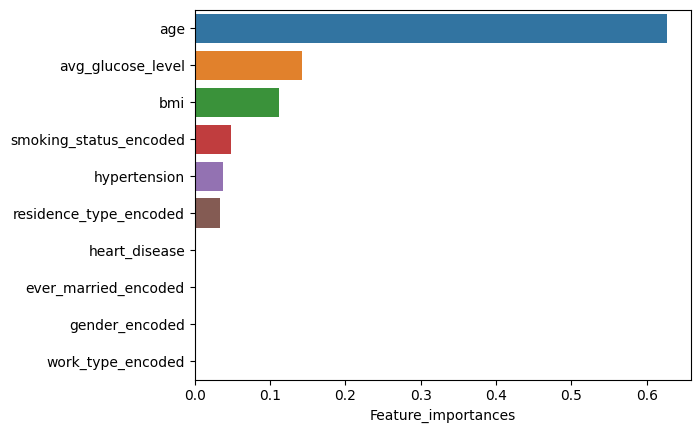

In [28]:
#데이터프레임 dft1의 막대그래프 그리기
import seaborn as sns

sns.barplot(y=dft1.index, x = "Feature_importances", data=dft1)

In [29]:
#트리 모양 확인을 위해 graphviz 불러오기
#import graphviz #위에서 수행했으니 일단 생략

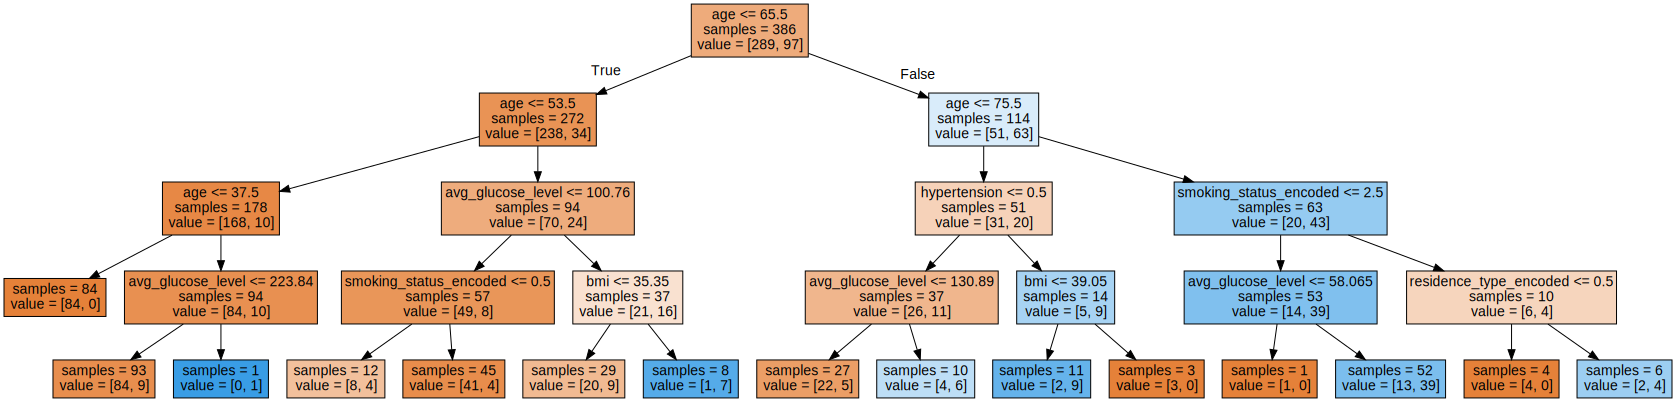

In [30]:
from sklearn.tree import export_graphviz
export_graphviz(best_clf, out_file = "tree.dot",
                feature_names=list(data.columns), impurity=False, filled=True)

#tree.dot을 graphviz 기능을 통해 출력

with open("tree.dot") as f:
  dot_graph = f.read()
display(graphviz.Source(dot_graph))